In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r "/content/drive/My Drive/NLP/assignment1/." "./"

In [2]:
# !pip install -r requirements.txt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import re
import os
import functools
import random
from typing import List, Callable, Dict, Iterable, Tuple, Set, Optional, Literal
from collections import OrderedDict
from enum import Flag, auto

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import keras as ks
import keras.backend as K
import keras_tuner

import gensim
import gensim.downloader as gloader

from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [6]:
#Config
words_separator = ' '
punctuation_tags = ['#', '$', 'SYM', "''", ',', '-LRB-', '-RRB-', '.', ':', '``']

In [7]:
# util
def flatten(seq: Iterable[Iterable]) -> List:
    return [item for inner in seq for item in inner]

def has_digits(input: str) -> bool:
    return any(char.isdigit() for char in input)

def is_number(input: str) -> bool:
  return bool(re.match(r'^[\-]?[0-9]*[\.,]?[0-9]+$', input))

def starts_with_uppercase(input: str) -> bool:
  return str.isupper(input[0])

def remove_items(dictionary: dict, keys: Iterable):
  for key in keys:
    dictionary.pop(key, None)

@tf.function
def tf_in(x, y) -> tf.Tensor:
  '''
  Returns True for each element of x that is contained in y
  '''
  # Exploit broadcasting
  # x:      N, 1
  # y:      1, M
  # x==y :  N x M
  # boolean mask:   N

  x = tf.expand_dims(x, axis=-1) # x:  N x 1
  return tf.math.reduce_any(x==y, axis=-1)

def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['SEED'] = str(seed)

def current_seed():
  return int(os.environ['SEED'])

In [8]:
set_reproducibility(42)

## 1. Dataset Loading

In [49]:
def read_tagged_sentences(filename: str) -> List[str]:
    with open(filename, mode='r', encoding='utf-8') as text_file:  
        corpus = text_file.read()
        return corpus.split("\n\n")

def get_tagged_words(tagged_sentence: str) -> List[str]:
    return tagged_sentence.rstrip('\n').split("\n")

def split_words_and_tags(tagged_words: List[str]) -> Tuple[List[str], List[str]]:
    words = []
    tags = []
    for tagged_word in tagged_words:
        word, tag = split_word_and_tag(tagged_word)
        words.append(word)
        tags.append(tag)
    return words, tags

def split_word_and_tag(tagged_word: str) -> Tuple[str, str]:
    entity = tagged_word.split("\t")
    # (word, tag)
    return entity[0], entity[1]

def read_data(filename) -> Tuple[List[str], List[str]]:
    tagged_sentences = read_tagged_sentences(filename)
    
    sentences: List[str] = []
    labels: List[str] = []
    for tagged_sentence in tagged_sentences:
        tagged_words = get_tagged_words(tagged_sentence)
        words, tags = split_words_and_tags(tagged_words)
        sentences.append(words_separator.join(words))
        labels.append(words_separator.join(tags))

    assert len(sentences) == len(tagged_sentences)
    assert len(labels) == len(tagged_sentences)

    return sentences, labels

def create_dataset(dataset_name="dependency_treebank", train_split=100, validation_split=150, test_split=199):
    def file_id_to_split(file_id: int):
        assert file_id <= test_split

        if file_id <= train_split:
            return 'train'
        if file_id <= validation_split:
            return 'validation'
        
        return 'test'

    dataset_folder = os.path.join(os.getcwd(), dataset_name)
    file_ids = []
    sentences = []
    labels = []
    for file_id in tqdm(range(1, test_split+1)):
        filename = os.path.join(dataset_folder, "wsj_%04d.dp" % file_id)
        sentences_, labels_ = read_data(filename)
        sentences += sentences_
        labels += labels_
        file_ids += [file_id] * len(sentences_)
         
    df = pd.DataFrame({'sentence': sentences, 'pos': labels, 'file_id': file_ids})
    df['split'] = df['file_id'].apply(file_id_to_split)
    
    df.to_pickle(os.path.join(os.getcwd(), dataset_name + ".pkl"))
    df.to_json(os.path.join(os.getcwd(), dataset_name + ".json"))
    return df

print("Creating dataset...")
df = create_dataset()
print("Creation completed!")

df

Creating dataset...


100%|██████████| 199/199 [00:00<00:00, 3934.67it/s]

Creation completed!


,sentence,pos,file_id,split
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ...",1,train
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN .",1,train
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN...",2,train
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...,3,train
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ...",3,train
...,...,...,...,...
3909,They also said that more than a dozen presiden...,PRP RB VBD IN JJR IN DT NN NNS VBP VBN IN JJ N...,198,test
3910,Sen. Kennedy said in a separate statement that...,NNP NNP VBD IN DT JJ NN IN PRP VBZ NN TO VB DT...,198,test
3911,Trinity Industries Inc. said it reached a prel...,NNP NNPS NNP VBD PRP VBD DT JJ NN TO VB CD NN ...,199,test
3912,Terms were n't disclosed .,NNS VBD RB VBN .,199,test


In [33]:
def split_dataset(dataset):    
    train_data = dataset[dataset['split'] == 'train']
    val_data = dataset[dataset['split'] == 'validation']
    test_data = dataset[dataset['split'] == 'test']
    return train_data, val_data, test_data

train_data, val_data, test_data = split_dataset(df)
print('Dataset splits statistics: ')
print(f'Train data: {train_data.shape}')
print(f'Validation data: {val_data.shape}')
print(f'Test data: {test_data.shape}')

Dataset splits statistics: 
Train data: (1963, 4)
Validation data: (1299, 4)
Test data: (652, 4)


# 2. Data Exploration and Analysis

## 2.1 Words analysis

In [11]:
# We should not look at test data
data = df[df['split'] != 'test'].copy()

words = set(flatten((sentence.split(words_separator) for sentence in data.sentence)))
lowered_case_words = set(map(str.lower, words))
n_words = len(words)

print("Total number of tagged sentences: {}".format(len(data)))
print("Total number of words: {}".format(n_words))
print("Total number of lowered case words: {}".format(len(lowered_case_words)))

Total number of tagged sentences: 3262
Total number of words: 10819
Total number of lowered case words: 9901


In [12]:
difference = words.difference(lowered_case_words)
print(len(difference))
difference

2896


{'Designated',
 'Circle',
 'R.D.',
 'Nationwide',
 'Marder',
 'Centers',
 'Dallas',
 'German',
 'Utilities',
 'Mossman',
 'S.I.',
 'Platt',
 'Howard',
 'Bureau',
 'No.',
 'Hummerstone',
 'Materials',
 'Osborn',
 'Ratners',
 'Impact',
 'Dolan',
 'Tire',
 'Watanabe',
 'Kawasaki',
 'C.D.s',
 'Other',
 'The',
 'Edward',
 'Clays',
 'Rapanelli',
 'Seymour',
 'Jovanovich',
 'Tuscany',
 'Norwick',
 'Cote',
 'Bolivia',
 'A-D',
 'Advocates',
 'France',
 'Polls',
 'Gas',
 'Kong',
 'Sunday',
 'Grace',
 'Earle',
 'Metropolitan',
 'Brunswick',
 'Perspective',
 'Their',
 'Bailey',
 'Fortune',
 'Caldor',
 'Baim',
 'Valrico',
 'Biscayne',
 'Social',
 'Brooklyn',
 'Genel',
 'Modifications',
 'Jerry',
 'Weisfield',
 'White',
 'Ailes',
 'Containers',
 'Nemeth',
 'Grandsire',
 'COMMERCIAL',
 'Connecticut',
 'Rothschild',
 'Visa',
 'Panama',
 'Net',
 'Sangyo',
 'Rozell',
 'Moving',
 'Kane',
 'LTV',
 'Ginsberg',
 'Henderson',
 'HHS',
 'Homebrew',
 'Whiting',
 'Whereas',
 'Ann',
 'Wis.',
 'Representative',
 '

There are sveral uppercase words:
1. -RRB-, -LRB- are already encoded into their tags
2. Some of them are abbreviations, e.g. U.S.A.
3. Some of them seem to be part of a title, e.g. LONDON, BIRDS

In [13]:
uppercase_words = [word for word in difference if str.isupper(word)]
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
print('Words encoded into their tags', tags.intersection(uppercase_words))
uppercase_words

Words encoded into their tags {'-RRB-', '-LRB-', 'TO'}


['R.D.',
 'S.I.',
 'A-D',
 'COMMERCIAL',
 'LTV',
 'HHS',
 'U.K.',
 'OVER',
 'LOAN',
 'F.W.',
 'SALT',
 'CDC',
 'CHANGED',
 'NIH',
 'M.',
 'MORTGAGE',
 'FUNDS',
 'N.',
 'Z.',
 'W.D.',
 'TIRED',
 'U.S.A',
 'RULING',
 'YMCA',
 'INTERBANK',
 'ISSUES',
 'TRUST',
 'C-90',
 'N.J',
 'F.H.',
 'SALARIES',
 "CREATOR'S",
 'UNION',
 'AIDS',
 'PLC',
 'CTBS',
 'LSI',
 'M.D.',
 'DIALING',
 'NESB',
 'GHS',
 'BALLOT',
 '-LCB-',
 'PETS',
 '-RRB-',
 'J.P.',
 'A.D.',
 'G',
 'ACQUISITION',
 'G.',
 'POTABLES',
 'DOONESBURY',
 'BILLS',
 'I',
 'ABORTION',
 'L.',
 'B.A.T',
 'WAR',
 'E.W.',
 'TWO',
 'N.C.',
 'A.C.',
 'C.J.B.',
 'R.P.',
 'W.R.',
 'YWCA',
 'OSHA',
 'WTVJ',
 'GM',
 'FERC',
 'I.',
 'NEC',
 'GAF',
 'CERTIFICATES',
 'TRIMMING',
 'TRS-80',
 'N.V',
 'AT&T',
 'WTD',
 'WFRR',
 'AC-130U',
 'LANDOR',
 'DOT',
 'MONEY',
 'SWITCHING',
 'N.C',
 'L.P.',
 'U.S.',
 'J.',
 'GHKM',
 'B.',
 'A.L.',
 'SAT',
 'US',
 'RATES',
 'MITI',
 'R.I.',
 'R',
 'BRAMALEA',
 'H.N.',
 '-LRB-',
 'N.Y.',
 'JUDGE',
 'SEC',
 'GOP',
 'T.

Words starting with capital letter are proper nouns or words at the beginning of a sentence. Therefore, this carries an important piece of information for POS tagging.

In [14]:
capitalized_words = set([word for word in difference if str.isupper(word[0])])
capitalized_words = capitalized_words.difference(uppercase_words)
print('Capitalized words:', len(capitalized_words))
capitalized_words

Capitalized words: 2622


{'Designated',
 'Circle',
 'Nationwide',
 'Marder',
 'Centers',
 'Dallas',
 'German',
 'Utilities',
 'Mossman',
 'Platt',
 'Howard',
 'Bureau',
 'No.',
 'Hummerstone',
 'Materials',
 'Osborn',
 'Ratners',
 'Impact',
 'Dolan',
 'Tire',
 'Watanabe',
 'Kawasaki',
 'C.D.s',
 'Other',
 'The',
 'Edward',
 'Clays',
 'Rapanelli',
 'Seymour',
 'Jovanovich',
 'Tuscany',
 'Norwick',
 'Cote',
 'Bolivia',
 'Advocates',
 'France',
 'Polls',
 'Gas',
 'Kong',
 'Sunday',
 'Grace',
 'Earle',
 'Metropolitan',
 'Brunswick',
 'Perspective',
 'Their',
 'Bailey',
 'Fortune',
 'Caldor',
 'Baim',
 'Valrico',
 'Biscayne',
 'Social',
 'Brooklyn',
 'Genel',
 'Modifications',
 'Jerry',
 'Weisfield',
 'White',
 'Ailes',
 'Containers',
 'Nemeth',
 'Grandsire',
 'Connecticut',
 'Rothschild',
 'Visa',
 'Panama',
 'Net',
 'Sangyo',
 'Rozell',
 'Moving',
 'Kane',
 'Ginsberg',
 'Henderson',
 'Homebrew',
 'Whiting',
 'Whereas',
 'Ann',
 'Wis.',
 'Representative',
 'Geneva',
 'Code',
 'Goldinger',
 'PaineWebber',
 'Louisvi

In [15]:
contains_digits = set([word for word in words if has_digits(word)])
numbers = set([word for word in contains_digits if is_number(word)])
non_numbers = contains_digits.difference(numbers)
print("Total number of words with digits:", len(contains_digits))
print("Total number of numbers:", len(numbers))
print("Total number of words with digits but that are not numbers:", len(non_numbers))
print(non_numbers)

Total number of words with digits: 792
Total number of numbers: 669
Total number of words with digits but that are not numbers: 123
{'14-hour', '190-point', '31-year-old', '11\\/16', 'AC-130U', '1950s', '14.', '382-37', '50-state', '5\\/8', '12-member', '300-113', '37-year-old', '500-stock', '1980s', 'pre-1933', 'Cray-3', '90-day', '2\\/32', '6\\/2', '30-point', '7\\/16', "'86", '55-year-old', '22\\/32', '51-year-old', '238,000-circulation', '59-year-old', '11th', '75-year-old', '100-share', '54-year-old', '3\\/8', '30-year', '15-day', "'40s", '9\\/32', '84-month', '10th', '1991-2000', '2003\\/2007', '1928-33', '300-a-share', 'nearly-30', '37-a-share', '1\\/2', '18-year-old', '12\\/32', '230-215', '150-point', '30-minute', '271-147', '3\\/4', '1,050,000', '21-month', '1:30', '90-cent-an-hour', 'pre-1917', 'C-90', "'82", '16\\/32', '1\\/8', 'Catch-22', '20-stock', '1986-87', '1st', '1\\/10th', '520-lawyer', '10-lap', '3-4', '36-day', 'mid-1970s', '1\\/4', '1991-1999', '69-point', '29yea

We have several wrongly escaped fractions, such as `6\\/2`, `1\\/4`, etc.

## 2.2 Classes Analysis

![tags](images/tags.png)

In [16]:
tags = set(flatten((pos.split(words_separator) for pos in df.pos)))
n_tags   = len(tags)
evaluation_tags = tags.difference(punctuation_tags)
n_evaluation_tags = len(evaluation_tags)
n_punctuation_tags = len(punctuation_tags)

print("Total number of tags:", n_tags)
print('Tags')
print(sorted(tags))
print()
print("Total number of tags valid for evaluation:", n_evaluation_tags)
print("Total number of punctuation tags:", n_punctuation_tags)
print('Punctuation tags')
print(punctuation_tags)

Total number of tags: 45
Tags
['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']

Total number of tags valid for evaluation: 35
Total number of punctuation tags: 10
Punctuation tags
['#', '$', 'SYM', "''", ',', '-LRB-', '-RRB-', '.', ':', '``']


In [17]:
tags = df[['pos', 'split']].copy()
tags['pos'] = tags['pos'].str.split(words_separator)
tags = tags.explode('pos')

The dataset is highly unbalanced: nouns, prepositions and proper nouns are the most common labels.

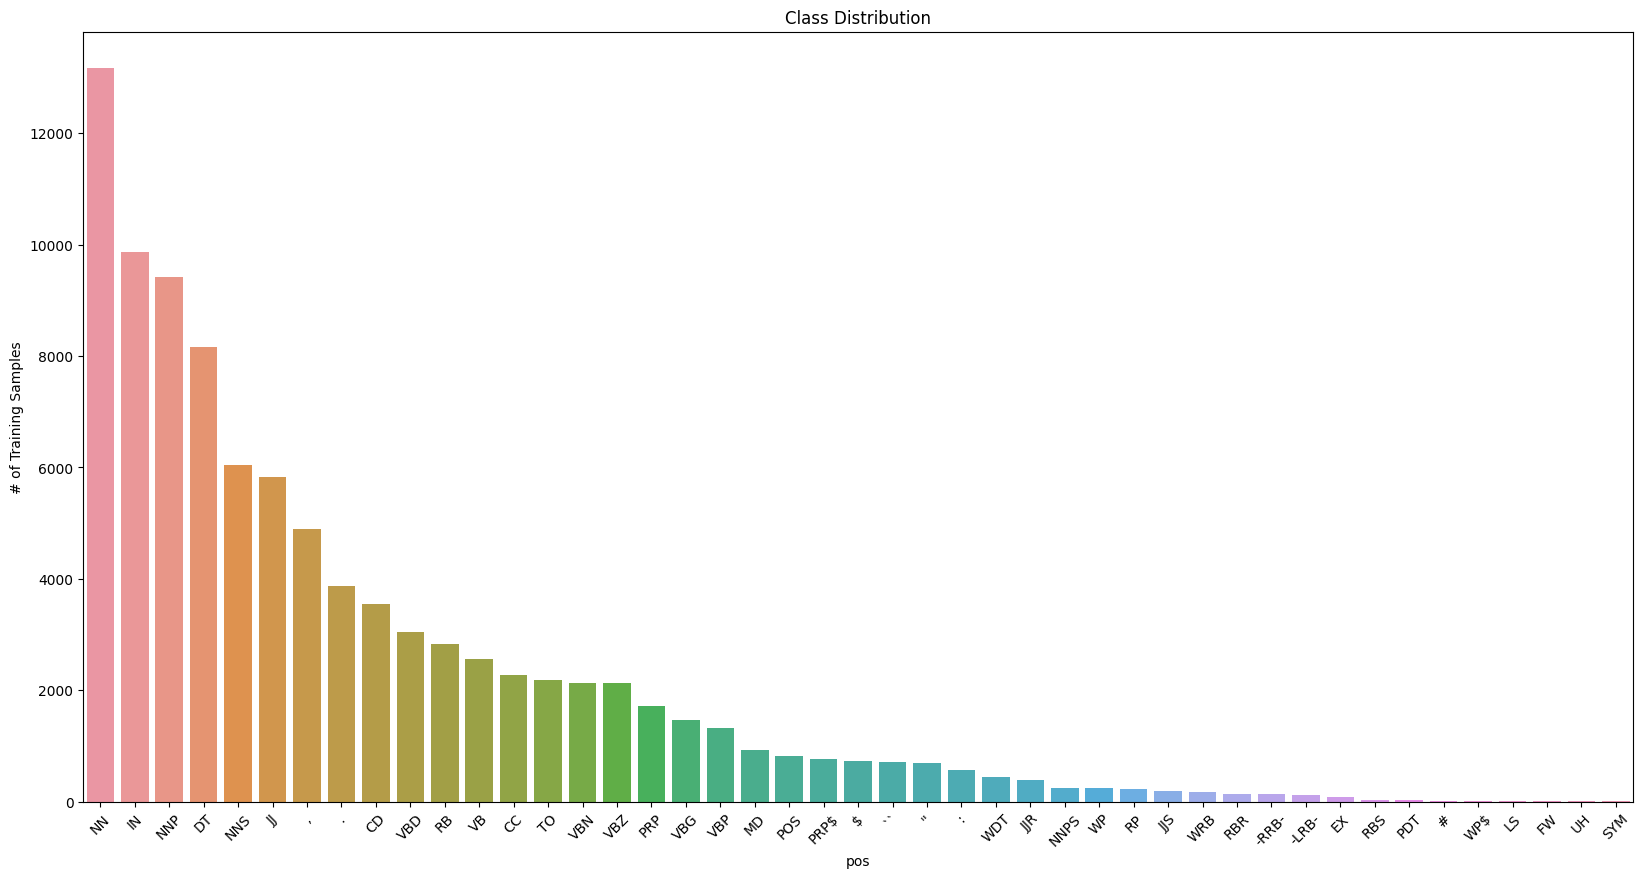

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(tags, x='pos', order=tags['pos'].value_counts().index, ax=ax);
plt.title('Class Distribution')
plt.ylabel('# of Training Samples')
plt.xticks(rotation = 45);

Classes are similarly distributed across the three splits

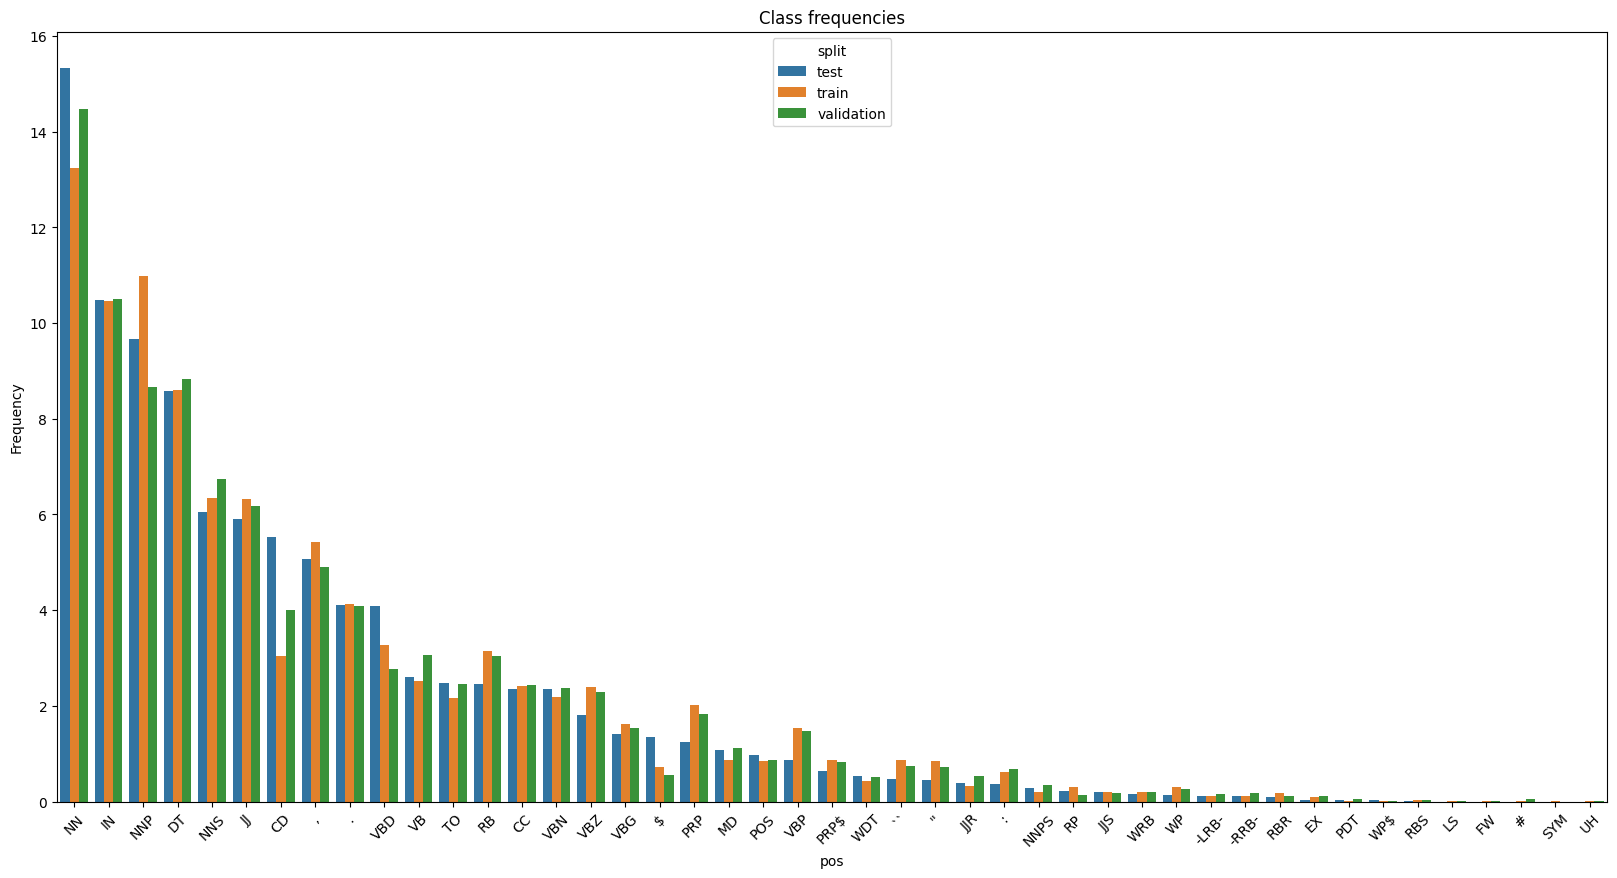

In [19]:
frequencies = (tags
    .groupby('split')['pos']
    .value_counts(normalize=True)
    .mul(100)
    .rename('frequency')
    .reset_index())

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(frequencies, x='pos', y='frequency', hue='split', ax=ax);
plt.title('Class frequencies')
plt.ylabel('Frequency')
plt.xticks(rotation = 45);

In [20]:
label_counts = pd.get_dummies(tags, columns=['pos'], prefix='', prefix_sep='').groupby('split').sum().reset_index()
cols = label_counts.columns[1:]
count_by_split = np.expand_dims(label_counts[cols].sum(axis=1), axis=1)
label_counts[cols] = label_counts[cols] / count_by_split
label_counts = label_counts.T.reset_index().rename(columns={'index':'pos', 0:'test', 1:'train', 2:'val'})[1:]
label_counts['punctuation'] = label_counts['pos'].isin(punctuation_tags)
label_counts.sort_values('test', ascending=False)

,pos,test,train,val,punctuation
20,NN,0.153297,0.132401,0.144726,False
14,IN,0.104857,0.10457,0.105025,False
21,NNP,0.096751,0.109849,0.086714,False
11,DT,0.08588,0.086071,0.088317,False
23,NNS,0.060534,0.063434,0.067409,False
15,JJ,0.059054,0.063181,0.0617,False
10,CD,0.055195,0.030387,0.040054,False
4,",",0.050627,0.054291,0.049001,True
7,.,0.041042,0.041368,0.040952,True
36,VBD,0.040785,0.032689,0.027611,False


In [21]:
label_counts.groupby('punctuation').sum().drop('pos', axis=1)

,test,train,val
punctuation,,,
False,0.879768,0.871569,0.879261
True,0.120232,0.128431,0.120739


Some classes are not present in the test set or in the validation set. In particular FW (foreign words), LS (list item markers), and UH (interjections)

In [22]:
cols = label_counts.columns[1:-1]
label_counts.loc[(label_counts[cols] == 0).any(axis=1)]

,pos,test,train,val,punctuation
1,#,0.0,0.000021,0.000481,True
13,FW,0.0,0.000042,0.000064,False
18,LS,0.0,0.000211,0.000096,False
32,SYM,0.0,0.000021,0.0,True
34,UH,0.0,0.000021,0.000064,False


## 2.3 Length Analysis

In [23]:
# We should not look at test data
data = df[df['split'] != 'test'].copy()
data['length'] = data['sentence'].str.split(words_separator).apply(len)

data['length'].describe()

count    3262.000000
mean       24.076947
std        12.229630
min         1.000000
25%        16.000000
50%        23.000000
75%        31.000000
max       249.000000
Name: length, dtype: float64

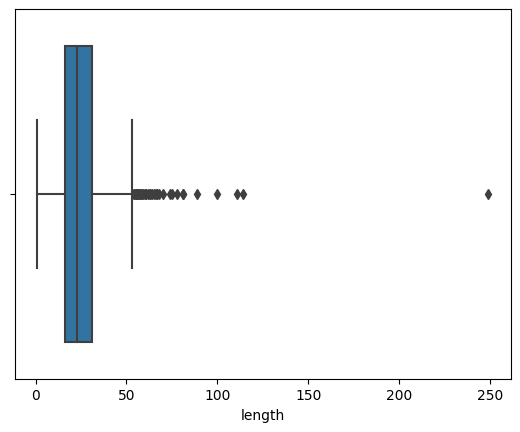

In [24]:
sns.boxplot(x=data['length']);

# 3. Data Preprocessing

*Text preprocessing*
We have lower case, upper case and capitalized words. Here we define three different strategies for preprocessing texts we will test:
- None: nothing is done
- lower: convert all words to the corresponding lower case string
- lower_up: convert only upper case words to the corresponding lower case string

The rationale of lower_up is that the upper case do not drive any information, therefore we make them lower to exploit embedding while preserving the case for capitalized words.

*Numbers preprocessing*
- None: nothing is done
- token: all numbers are replaced with a common token

In [50]:
# TODO: Handle abbreviations like USA and U.S.A.
def preprocess_text(sentence: str, text_strategy:Optional[Literal['lower', 'lower_up']]=None, number_strategy:Optional[Literal['token']]=None) -> str:
  def lower_up(sentence: str):
    for word in sentence.split(words_separator):
      if str.isupper(word):
        yield word.lower()

  # restore slash (/)
  sentence = sentence.replace('\\/', '/')
  
  if text_strategy == 'lower':
    sentence = sentence.lower()
  elif text_strategy == 'lower_up':
    sentence = [lower_up(sentence)]

  if number_strategy == 'token':
    # a32.4b -> a32.4b, 32.4 -> [NUMBER]
    sentence = re.sub(r'(\s|^)([\-]?[0-9]*[\.,]?[0-9]+)(?=\s|$)', r'\1[NUMBER]', sentence)

  return sentence

df['sentence'] = df['sentence'].apply(preprocess_text)
train_data, val_data, test_data = split_dataset(df)
df

,sentence,pos,file_id,split
0,"Pierre Vinken , 61 years old , will join the b...","NNP NNP , CD NNS JJ , MD VB DT NN IN DT JJ NN ...",1,train
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...","NNP NNP VBZ NN IN NNP NNP , DT NNP VBG NN .",1,train
2,"Rudolph Agnew , 55 years old and former chairm...","NNP NNP , CD NNS JJ CC JJ NN IN NNP NNP NNP NN...",2,train
3,A form of asbestos once used to make Kent ciga...,DT NN IN NN RB VBN TO VB NNP NN NNS VBZ VBN DT...,3,train
4,"The asbestos fiber , crocidolite , is unusuall...","DT NN NN , NN , VBZ RB JJ IN PRP VBZ DT NNS , ...",3,train
...,...,...,...,...
3909,They also said that more than a dozen presiden...,PRP RB VBD IN JJR IN DT NN NNS VBP VBN IN JJ N...,198,test
3910,Sen. Kennedy said in a separate statement that...,NNP NNP VBD IN DT JJ NN IN PRP VBZ NN TO VB DT...,198,test
3911,Trinity Industries Inc. said it reached a prel...,NNP NNPS NNP VBD PRP VBD DT JJ NN TO VB CD NN ...,199,test
3912,Terms were n't disclosed .,NNS VBD RB VBN .,199,test


# 4. Embedding

In [26]:
def load_embedding_model(model_type: str='glove', embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [27]:
model_type = 'glove'
embedding_dimension = 50
embedding_model_file = f'{model_type}_{embedding_dimension}.kv'

embedding_model = load_embedding_model(model_type=model_type, embedding_dimension=embedding_dimension)
embedding_model.save(embedding_model_file)

## 4.1 Embedding Analysis

In [28]:
embedding_words = set(embedding_model.key_to_index.keys())
n_embedding_words = len(embedding_words)
print("Total number of words into embeddings:", n_embedding_words)
lower = [word for word in embedding_words if str.islower(word)]
print("All lowercase?", len(lower) == n_embedding_words)

Total number of words into embeddings: 400000
All lowercase? False


In [29]:
embedding_contains_digits = set([word for word in embedding_words if has_digits(word)])
embedding_numbers = set([word for word in embedding_contains_digits if is_number(word)])
embedding_non_numbers = embedding_contains_digits.difference(embedding_numbers)
print("Total number of embedding words with digits:", len(embedding_contains_digits))
print(list(embedding_contains_digits)[:100])
print()
print("Total number of embedding numbers:", len(embedding_numbers))
print(list(embedding_numbers)[:100])
print()
print("Total number of embedding words with digits but that are not numbers:", len(embedding_non_numbers))
print(list(embedding_non_numbers)[:300])

Total number of embedding words with digits: 48970
['117.99', '74-77', '1.085', '30-goal', '15.29', '037', '6-to-1', '.378', '1950s', '34.72', '747-100', '95.1', 'ia-32', '13-party', 'mid-1944', '99s', '9.86', '128.7', '226-3346', '100.15', '1685', '23.24', '13:19', '79.08', '18-wheelers', '5,550', '6am', '2.257', '229.8', '736,000', '7th-8th', '67.58', '30-man', '1962-1967', '199.3', 'mo95', '990', '4,526', '80-column', '32.40', '18:20', '141-member', '1-rustu', '58.31', '22-year-old', '56-kilobit', '2-seed', '88.0', '98.14', '35.9', '149th', '33-car', '2,170', '38.3', '19-page', '1980-1986', '24.08', '33.39', '2004-present', '112.88', '549,000', 'formula_45', '30.05', '89.16', ',1', '48.57', 'tvn24', '2313', '10-yards', '20-game', '30.03', '2-0-13-0', '2.8-million', '1,467', '72.46', '115.63', '1,761', 'f-28', '1.27', '33.93', '96.41', '18-arrow', 'g7-economy', 'yak-130', '3-axis', '83.94', '12-piece', '1848', '106.98', '57.42', '11:26', '297', '3:26', '33.40', '31.79', '1053', '4-86

In [30]:
discard = set(lower).union(embedding_contains_digits)
remaining = embedding_words.difference(discard)
print('Total number of words that are neither lower case text nor words with digits:', len(remaining))
print(remaining)

Total number of words that are neither lower case text nor words with digits: 322
{'ಹ', '同中書門下平章事', '李', 'ම', '`', 'ത', '⅝', '_________', '--------------', 'الدين', 'ابن', '@', '------------------------', '揚州', 'ದ', '_______________', '/', '____________________________________________', '尚書省', '_______', 'א', '________________________', '------', '!', '-----------------------------------------------', '門下省', ':@', 'ත', '_____', '河東', '?', '_________________________________', '￥', 'ನ', 'خان', '~', '””', '<', '---------------------------------------------------------', '中書舍人', ':-)', '....', '______________________________', 'की', 'ស', '???', '---------', '、', '%', '\\', 'ס', 'احمد', '[', '’‘', '淮南', '---------------------', 'های', '}', '”', '"', '----', '¿', 'ត', '--------', 'گیتاشناسی', '_____________________________________', 'أحمد', '魏博', 'الله', 'है', 'في', '_____________________________', '˚', 'പ', ':)', '’’', 'ಜ', '中書省', 'حسن', '--------------------------------------------------',

## 4.2 Handling OOV
From the analysis above, we can see that all words in glove are lower case. Words that contains numbers are compositions of numbers-text. We can handle OOV in the following way:
- composed-words: we take as vector the mean of the single words vectors
- numbers: we consider one common embedding vector for all the numbers taken as the mean of all the numbers vectors
- capitalized words: we add to the corresponding lower case vector a common "capitalize" vector

In [31]:
class OOVStrategy(Flag):
  NONE = 0
  COMPOSED_WORDS = auto()
  NUMBER_EMBEDDING = auto()
  CAPITALIZED_EMBEDDING = auto()

class EmbeddingMatrix():
  def __init__(self,
               embedding_model: gensim.models.keyedvectors.KeyedVectors,
               oov_strategy: OOVStrategy = OOVStrategy.NONE,
               padding = True,
               number_token = '[NUMBER]',               
               capitalize_vector: np.ndarray = None) -> None:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param embedding_dimension: dimension of the vectors in the embedding space
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """
    
    self.__composed_words_delimiters = ['-', '_', '/']
    self.oov_strategy = oov_strategy
    self.number_token = number_token
    
    tokens, vectors = self.__get_embeddings(embedding_model, padding)
    self.embedding_model = gensim.models.keyedvectors.KeyedVectors(embedding_model.vector_size)
    self.embedding_model.add_vectors(tokens, vectors)

    self.capitalize_vector = capitalize_vector
    if OOVStrategy.CAPITALIZED_EMBEDDING in self.oov_strategy and capitalize_vector is None:
      self.capitalize_vector = np.repeat(0.1, embedding_model.vector_size)

  def __get_embeddings(self, embedding_model: gensim.models.keyedvectors.KeyedVectors, padding: bool):
    tokens=[]
    vectors=[]
    embedding_word_to_id = embedding_model.key_to_index.copy()
    
    if padding:
      tokens.append('')
      vectors.append(np.zeros(embedding_model.vector_size))

    if OOVStrategy.NUMBER_EMBEDDING in self.oov_strategy:
      embedding_numbers = [word for word in embedding_word_to_id.keys() if is_number(word)]
      number_vector = embedding_model.get_mean_vector(embedding_numbers)
      remove_items(embedding_word_to_id, embedding_numbers)
      tokens.append(self.number_token)
      vectors.append(number_vector)

    for token, id in tqdm(embedding_word_to_id.items()):
      tokens.append(token)
      vectors.append(embedding_model[id])
    
    return tokens, vectors

  def add_tokens(self, tokens: Iterable[str]):
    previous_terms = set(self.embedding_model.key_to_index.keys())
    tokens = set(tokens)
    oov = tokens.difference(previous_terms)
    n_oov = len(oov)

    self.embedding_model.add_vectors(list(oov), np.zeros((n_oov, self.embedding_model.vector_size)))
    for token in tqdm(oov):
      self.add_token(token)
    
    new_tokens = list(set(self.embedding_model.key_to_index.keys()).difference(previous_terms))
    print('Number of OOV terms:', n_oov)
    print('Number of new tokens:', len(new_tokens))
    return new_tokens

  def add_token(self, token: str):
    # If already created, return
    if np.any(self.embedding_model[self.embedding_model.key_to_index[token]] != 0):
      return

    self.embedding_model[token] = np.random.uniform(low=-0.05, high=0.05, size=self.embedding_model.vector_size)

    if OOVStrategy.CAPITALIZED_EMBEDDING in self.oov_strategy and starts_with_uppercase(token):
      # we ensure that the lower case form of the word is in the embedding matrix
      self.embedding_model[token] = self.__get_vector_or_handle_as_oov(token.lower()) + self.capitalize_vector
    
    elif OOVStrategy.COMPOSED_WORDS in self.oov_strategy:
      sub_tokens = self.__split_composed(token)
      if len(sub_tokens) > 1:
        self.embedding_model[token] = np.mean([self.__get_vector_or_handle_as_oov(sub_token) for sub_token in sub_tokens])

  def __get_vector_or_handle_as_oov(self, token: str):
    if OOVStrategy.NUMBER_EMBEDDING in self.oov_strategy and is_number(token):
      return self.embedding_model.get_vector(self.number_token)

    # if not present, initialize it
    if not self.embedding_model.has_index_for(token):
      self.embedding_model.add_vector(token, np.zeros(self.embedding_model.vector_size))

    id = self.embedding_model.key_to_index[token]
    vector = self.embedding_model[id]
    # if not created, create it
    if np.all(vector == 0):      
      self.add_token(token)
      vector = self.embedding_model[id]

    return vector  

  def __split_composed(self, token: str) -> List[str]:
    return re.split(self.__composed_words_delimiters, token)

  def __is_composed(self, token: str) -> bool:
    return len(self.__split_composed(token)) > 1

  def vectors(self) -> np.ndarray:
    return self.embedding_model.vectors

In [35]:
def add_dataset_terms(embedding_matrix: EmbeddingMatrix, dataset, dataset_name: str):
  print(f'Adding {dataset_name} terms ...')
  tokens = flatten(dataset.sentence.str.split(words_separator))
  new_tokens = embedding_matrix.add_tokens(tokens)
  print('New tokens:', new_tokens[:300])


embedding_model = gensim.models.keyedvectors.KeyedVectors.load(embedding_model_file)
embedding_matrix = EmbeddingMatrix(embedding_model)
assert np.all(embedding_matrix.embedding_model.vectors[1:] == embedding_model.vectors)
add_dataset_terms(embedding_matrix, train_data, 'training set')
add_dataset_terms(embedding_matrix, val_data, 'validation set')
add_dataset_terms(embedding_matrix, test_data, 'test set')

100%|██████████| 400000/400000 [00:00<00:00, 766206.77it/s]


Adding training set terms ...


100%|██████████| 2346/2346 [00:29<00:00, 80.34it/s]


Number of OOV terms: 2346
Number of new tokens: 2346
New tokens: ['Circle', 'Marder', 'Centers', 'Dallas', 'German', 'Mossman', 'Utilities', 'Platt', 'Bureau', 'No.', 'Hummerstone', 'Materials', 'Osborn', 'Ratners', 'Tire', 'Kawasaki', 'Watanabe', 'Other', 'The', 'Edward', 'Rapanelli', 'Clays', 'Jovanovich', 'Seymour', 'Tuscany', 'Norwick', 'Cote', 'automotive-lighting', 'Advocates', 'France', 'Polls', 'Kong', 'Sunday', 'Earle', 'Grace', 'Metropolitan', 'Brunswick', 'Their', 'Fortune', 'Bailey', 'Valrico', 'Biscayne', 'Social', 'Brooklyn', 'Genel', 'Jerry', 'Modifications', 'Weisfield', 'White', 'rope-sight', 'Ailes', 'Containers', 'Nemeth', 'Grandsire', 'Connecticut', 'anti-abortionists', 'replacement-car', 'Rothschild', 'Panama', 'Net', 'Rozell', 'Moving', 'Kane', 'LTV', 'Henderson', 'Ginsberg', 'HHS', 'Homebrew', 'Whiting', 'odd-sounding', 'Ann', 'Representative', 'Code', 'U.K.', 'Goldinger', 'PaineWebber', 'Louisville', 'Tache', 'Sales', 'Calder', '1\\/10th', 'Wells', 'Burt', 'Rese

100%|██████████| 944/944 [00:11<00:00, 80.14it/s]


Number of OOV terms: 944
Number of new tokens: 944
New tokens: ['Designated', 'Noriega', 'Provided', '47.125', 'Nationwide', 'airline-related', 'Gates-Warren', 'Amsterdam', 'Elsewhere', 'Julia', 'Backseat', 'R.D.', '23,403', '11\\/16', 'Resources', 'pricings', 'S.I.', '14.', 'crystal-lattice', 'English-speaking', 'Colleges', 'Sweden', 'Howard', 'Tribune', 'Bonds', 'CORP', 'Impact', 'then-Speaker', 'Dolan', 'Anti-Deficiency', 'YWCA', 'Moines', 'Barth', 'C.D.s', 'Stadiums', 'Deere', 'Consequence', 'contingency-fee', 'Hoylake', 'Riviera', 'Pencil', 'Montgomery', 'clean-air', 'Clairton', 'GMAC', 'Edwin', '6\\/2', 'Takashima', 'Andy', 'DES', 'Charities', 'pension-fund', 'Earnings', 'Harper', 'Cup-Tote', 'SuperDot', 'Payments', 'Bolivia', 'Stieglitz', 'Antitrust', 'OSHA', 'Weil', 'A-D', 'Register', 'Bricklayers', 'non-U.S.', 'Turnaround', 'Jail', 'Possible', 'Gas', 'Knopf', 'bank-backed', '5.435', 'Perspective', 'Whether', 'propagandizes', 'Commissions', 'Caldor', 'Iran-Contra', 'Baim', '173

100%|██████████| 455/455 [00:05<00:00, 80.27it/s]

Number of OOV terms: 455
Number of new tokens: 455
New tokens: ['Kennedy', 'Meridian', 'minimum-wage', 'Thousands', '1.637', '26,956', 'CSV', 'EST', 'weapons-modernization', 'Elders', 'COPPER', 'GenCorp', '11,390,000', 'protein-1', '300-day', 'Junk-bond', 'Inland', 'Bradford', 'Africa', 'Ratner', '55-a-share', 'Disputado', 'Bribe', '1.916', '377.60', '618.1', 'prior-year', 'AMR', 'Nofzinger', 'Derchin', 'Allendale', 'Pakistan', 'acquisition-minded', "O'Neill", 'Per-share', 'Wedtech', 'Possibly', 'Lobsenz', 'Congressman', '500-Stock', 'Lines', 'cents-a-unit', '494.50', 'Komatsu', '170,262', 'Eveready', 'passenger-car', 'Icahn', 'Lyle', 'Fourteen', 'Biaggi', 'Cos.', 'Similar', 'Forster', 'Lyn', 'MacLellan', 'Sandoz', 'Johnson-era', 'Numerous', 'DiLoreto', 'Waterloo', 'Sanford', 'Angola', 'Warehouse', 'Concurrent', 'Advancing', 'Waertsilae', 'Third', 'Andean', 'Continental', 'Brazilian', 'Irwin', 'Genetics', 'Laurence', 'Mead', '40-megabyte', 'Paper', 'Professors', '226,570,380', 'G.m.b',

In [24]:
class Vocabulary:
  def __init__(self, padding=True) -> None:
    self.word_to_id = OrderedDict()
    self.id_to_word = OrderedDict()
    self.__id = 0

    if padding:
      self.word_to_id[''] = 0
      self.id_to_word[0] = ''
      self.__id += 1

  def update(self, tokens: Iterable[str], verbose=True) -> Iterable[str]:
    """
    Update the vocabulary by looking at the list of tokens in input.

    :return
        - OOV terms
    """
    old_len = len(self.word_to_id)

    oov = self.__compute_oov_terms(tokens)
    self.__expand_vocabulary(oov)

    if verbose:
      print(f"Total OOV terms:", len(oov))
      print("Vocabulary length before expansion:", old_len)
      print("Vocabulary length after expansion:", len(self.word_to_id))
  
  def __compute_oov_terms(self, tokens: Iterable[str]) -> Set[str]:
    """
    Get tokens which are not in the vocabulary.

    :return
        - OOV terms
    """
    tokens = set(tokens)
    oov = tokens.difference(self.word_to_id.keys())
    return oov

  def __expand_vocabulary(self, oov_terms: Iterable[str]):
    for term in oov_terms:
      self.word_to_id[term] = self.__id
      self.id_to_word[self.__id] = term
      self.__id += 1

  def __len__(self):
    return len(self.word_to_id)

In [27]:
def add_oov(vocabulary: Vocabulary, embedding_matrix: EmbeddingMatrix, dataset, dataset_name: str):
  print(f'Adding {dataset_name} vocabulary ...')

  tokens = flatten(dataset.sentence.str.split(words_separator))
  vocabulary.update(tokens)
  embedding_matrix.update(vocabulary.word_to_id)

def build_vocabulary_and_embedding(embedding_model: gensim.models.keyedvectors.KeyedVectors):
  vocabulary = Vocabulary()

  embedding_terms = embedding_model.key_to_index.keys()
  vocabulary.update(embedding_terms)

  embedding_matrix = EmbeddingMatrix(embedding_model, embedding_dimension, vocabulary.word_to_id)

  add_oov(vocabulary, embedding_matrix, train_data, 'training set')
  add_oov(vocabulary, embedding_matrix, val_data, 'validation set')
  add_oov(vocabulary, embedding_matrix, test_data, 'test set')

  return vocabulary, embedding_matrix

vocabulary, embedding_matrix = build_vocabulary_and_embedding(embedding_model)

Total OOV terms: 400000
Vocabulary length before expansion: 1
Vocabulary length after expansion: 400001


100%|██████████| 400001/400001 [00:02<00:00, 161272.49it/s]



Adding training set vocabulary ...
Total OOV terms: 2346
Vocabulary length before expansion: 400001
Vocabulary length after expansion: 402347


100%|██████████| 402347/402347 [00:00<00:00, 1381516.83it/s]



Adding validation set vocabulary ...
Total OOV terms: 944
Vocabulary length before expansion: 402347
Vocabulary length after expansion: 403291


100%|██████████| 403291/403291 [00:00<00:00, 1414792.97it/s]



Adding test set vocabulary ...
Total OOV terms: 455
Vocabulary length before expansion: 403291
Vocabulary length after expansion: 403746


100%|██████████| 403746/403746 [00:00<00:00, 1377239.85it/s]


In [28]:
label_vocabulary = Vocabulary()
labels = flatten((pos.split(words_separator) for pos in df.pos))
label_vocabulary.update(labels)

assert len(label_vocabulary) == n_tags + 1

Total OOV terms: 45
Vocabulary length before expansion: 1
Vocabulary length after expansion: 46


In [71]:
class TextVectorization:
    def __init__(self, word_to_id: Dict[str, int], sep=' ') -> None:
        self.sep = sep

        words = list(word_to_id.keys())
        values = list(word_to_id.values())
        self.word_to_id = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(words, values),
            default_value=-1
        )
        self.id_to_word = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(values, words),
            default_value='[UNK]'
        )
        assert self.word_to_id.size() == len(word_to_id)
        assert self.id_to_word.size() == len(word_to_id)

    def vectorize(self, text) -> tf.RaggedTensor:
        tokens = self.tokenize(text)
        return self.tokens_to_ids(tokens)
    
    def invert(self, ids: tf.RaggedTensor) -> tf.RaggedTensor:
        tokens = self.ids_to_tokens(ids)
        texts = tf.strings.reduce_join(tokens, separator=self.sep, axis=-1)
        return texts

    def tokenize(self, text) -> tf.RaggedTensor:
        tokens = tf.strings.split(text, sep=self.sep)
        return tokens

    def tokens_to_ids(self, tokens: tf.RaggedTensor | list | tuple | np.ndarray) -> tf.RaggedTensor:        
        if isinstance(tokens, (list, tuple, np.ndarray)):
            tokens = tf.ragged.constant(tokens)
        return tf.ragged.map_flat_values(self.word_to_id.lookup, tokens)
    
    def ids_to_tokens(self, ids: tf.RaggedTensor) -> tf.RaggedTensor:        
        ids = tf.cast(ids, tf.int32)
        tokens = tf.ragged.map_flat_values(self.id_to_word.lookup, ids)
        return tokens

tokenizer = TextVectorization(vocabulary.word_to_id)
label_tokenizer = TextVectorization(label_vocabulary.word_to_id)

assert tf.reduce_all(tokenizer.invert(tokenizer.vectorize(train_data.sentence.values)) == tf.constant(train_data.sentence.values))
assert tf.reduce_all(label_tokenizer.invert(label_tokenizer.vectorize(train_data.pos.values)) == tf.constant(train_data.pos.values))

In [51]:
def one_hot(inputs: tf.Tensor, num_classes, ignore_padding=False):
  if ignore_padding:
    # supposing padding=0 -> padding=-1 -> padding = [0,...,0]
    inputs -= 1
  else:
    num_classes += 1
  return tf.one_hot(inputs, depth=num_classes)

def one_hot_to_ids(one_hot: tf.Tensor, ignore_padding=False) -> tf.Tensor:
    ids = tf.argmax(one_hot, axis=-1, output_type=tf.int32)
    assert one_hot.shape[:2] == ids.shape
    
    if ignore_padding:
      ids += 1

    return ids

def pad(sentences: tf.RaggedTensor, tags: tf.RaggedTensor):
  sentences = sentences.to_tensor(default_value=0)
  tags = tags.to_tensor(default_value=0)

  return sentences, tags

# workaround to avoid lambda functions
def one_hot_encode_labels(sentences: tf.Tensor, tags: tf.Tensor, num_classes, ignore_padding):
  return sentences, one_hot(tags, num_classes, ignore_padding)

def create_dataloader(
  dataset: pd.DataFrame,
  tokenizer: TextVectorization,
  label_tokenizer: TextVectorization,
  batch_size=32,
  multi_label=False, training=True):

  sentences = tokenizer.vectorize(dataset['sentence'])
  labels = label_tokenizer.vectorize(dataset['pos'])

  dataset = (
      tf.data.Dataset.from_tensor_slices((sentences, labels))
  )
  
  if training:
    dataset = dataset.shuffle(buffer_size=2048)

  # workaround to avoid lambda functions
  encode_labels = functools.partial(one_hot_encode_labels, num_classes=n_tags, ignore_padding=multi_label)

  dataset = (
      dataset
      .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
      .map(pad, num_parallel_calls=tf.data.AUTOTUNE)
      .map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE)
      )
  
  return dataset

dataloader = create_dataloader(train_data, tokenizer, label_tokenizer)

In [31]:
batched_text, batched_tags = next(dataloader.take(1).as_numpy_iterator())
text = batched_text[0]
tags = batched_tags[0]

print('Encoded text:', text.shape)
print(text)
print('One hot encoded tags:', tags.shape)
print(tags)

Encoded text: (46,)
[400524 401241 162613  23311 341628 274586 157599  69913 232413      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]
One hot encoded tags: (46, 46)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## 1.5 Model Definition

In [32]:
class TimeDistributedDense(ks.layers.TimeDistributed):
  def __init__(self, *dense_args, **dense_kwargs) -> None:
        super().__init__(ks.layers.Dense(*dense_args, **dense_kwargs))        

class ModelFactory():
  def __init__(self, embedding_weights, n_tags):
    self.embedding_weights=embedding_weights
    self.n_tags=n_tags
  
  def create_model(self,
              rnn_units=128,
              use_gru=False, 
              additional_lstm=False,
              additional_dense=False,
              additional_dense_units=10,
              dropout=0.0,
              multi_label=False,
              name = None):
    """
    Parameters
      ----------
      rnn_units: int
          The hidden state's dimension of the RNNs
      use_gru: bool
          If True, use a BiGRU layer instead of the BiLSTM
      additional_lstm: bool
          If True, use an additional BiLSTM layer right after the default one
      additional_dense: bool
          If True, adds a FC layer before the classifier
      additional_dense_units: int
        The hidden state's dimension of the additional dense layers
      dropout: float
          Define the drop rate of the Dropout layers. By default the dropout is disabled
      multi_label: bool
        If True, the problem is considered to be multi label and the last layer uses sigmoid instead of softmax
      name: str
          The name of the model          
      Returns
      -------
      tensorflow.keras.models.Model
          The POS-tagging model          
    """
    
    inputs = ks.layers.Input(shape=(None, ))
    x = ks.layers.Embedding(*self.embedding_weights.shape, weights=[self.embedding_weights],
                            mask_zero=True, trainable=False)(inputs)

    if use_gru:
      assert not additional_lstm and not additional_dense, "use_gru cannot be used together with additional_lstm or additional_dense"
      rnn = ks.layers.GRU(units=rnn_units, return_sequences=True, dropout=dropout, name='gru')
    else:
      rnn = ks.layers.LSTM(units=rnn_units, return_sequences=True, dropout=dropout, name='lstm')
    x = ks.layers.Bidirectional(rnn, name=f'bidirectional_{rnn.name}')(x)

    if additional_lstm:
      assert not use_gru and not additional_dense, "additional_lstm cannot be used together with use_gru or additional_dense"
      rnn = ks.layers.LSTM(units=rnn_units, return_sequences=True, dropout=dropout)
      x = ks.layers.Bidirectional(rnn, name='bidirectional_lstm2')(x)

    if additional_dense:
      assert not use_gru and not additional_lstm, "additional_dense cannot be used together with use_gru or additional_lstm"
      assert additional_dense_units > 0
      x = TimeDistributedDense(additional_dense_units, activation='relu')(x)
      if dropout:
        x = ks.layers.Dropout(dropout)(x)

    if multi_label:        
      x = TimeDistributedDense(self.n_tags, activation='sigmoid', dtype=np.float32)(x)
    else:
      x = TimeDistributedDense(self.n_tags+1, activation='softmax', dtype=np.float32)(x)

    return ks.models.Model(inputs, x, name=name)

In [33]:
models = {}
models['base'] = {
    'name': 'base',
    'use_gru': False,
    'additional_lstm': False,
    'additional_dense': False,
}
models['gru'] = {
    'name': 'gru',
    'use_gru': True,
    'additional_lstm': False,
    'additional_dense': False,
}
models['additional_lstm'] = {
    'name': 'additional_lstm',
    'use_gru': False,
    'additional_lstm': True,
    'additional_dense': False,
}
models['additional_dense'] = {
    'name': 'additional_dense',
    'use_gru': False,
    'additional_lstm': False,
    'additional_dense': True,
}

model_factory = ModelFactory(embedding_matrix.numpy(), n_tags=n_tags)
for model_name, architecture in models.items():
  model = model_factory.create_model(**architecture)
  model.summary()
  print()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 50)          20187300  
                                                                 
 bidirectional_lstm (Bidirec  (None, None, 256)        183296    
 tional)                                                         
                                                                 
 time_distributed_dense (Tim  (None, None, 46)         11822     
 eDistributedDense)                                              
                                                                 
Total params: 20,382,418
Trainable params: 195,118
Non-trainable params: 20,187,300
_________________________________________________________________

Model: "gru"
______________________________

In [34]:
compile_info = {
    'optimizer': ks.optimizers.Adam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
    'metrics': ['categorical_accuracy'],
}

model = model_factory.create_model(**models['base'])
model.summary()
model.compile(**compile_info)

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 50)          20187300  
                                                                 
 bidirectional_lstm (Bidirec  (None, None, 256)        183296    
 tional)                                                         
                                                                 
 time_distributed_dense_5 (T  (None, None, 46)         11822     
 imeDistributedDense)                                            
                                                                 
Total params: 20,382,418
Trainable params: 195,118
Non-trainable params: 20,187,300
_________________________________________________________________


## 1.6 Training

In [35]:
def show_history(history: ks.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
    plt.show()

In [36]:
def train_model(model: ks.Model,
                train_data: tf.data.Dataset,
                val_data: tf.data.Dataset,
                training_info: Dict,
                show=True):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param train_data: training data
    :param val_data: validation data
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """
    print(f"Start training! \nParameters: {training_info}")
    history = model.fit(x=train_data,
                        validation_data=val_data,
                        **training_info)
    print("Training completed!")

    if show:
        print("Showing history...")
        show_history(history)

    return history

Start training! 
Parameters: {'verbose': 1, 'epochs': 5, 'batch_size': 64}
Epoch 1/5
31/31 [==============================] - 33s 597ms/step - loss: 2.9725 - categorical_accuracy: 0.2336 - val_loss: 2.5285 - val_categorical_accuracy: 0.3752
Epoch 2/5
31/31 [==============================] - 14s 471ms/step - loss: 2.1747 - categorical_accuracy: 0.4614 - val_loss: 1.8645 - val_categorical_accuracy: 0.5240
Epoch 3/5
31/31 [==============================] - 14s 465ms/step - loss: 1.5802 - categorical_accuracy: 0.5999 - val_loss: 1.4175 - val_categorical_accuracy: 0.6375
Epoch 4/5
31/31 [==============================] - 16s 509ms/step - loss: 1.2401 - categorical_accuracy: 0.6875 - val_loss: 1.1844 - val_categorical_accuracy: 0.6920
Epoch 5/5
31/31 [==============================] - 16s 516ms/step - loss: 1.0498 - categorical_accuracy: 0.7319 - val_loss: 1.0420 - val_categorical_accuracy: 0.7243
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss'

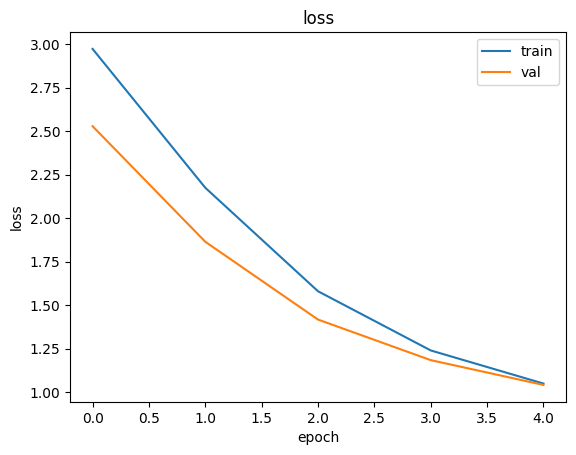

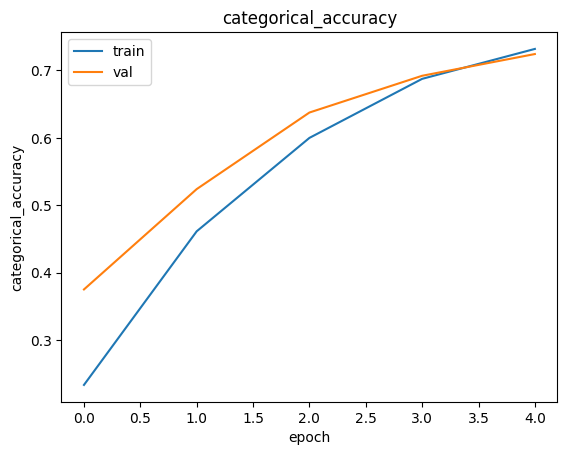

In [37]:
training_info = {
    'verbose': 1,
    'epochs': 5,
    'batch_size': 64,
}

train_dataloader = create_dataloader(train_data, tokenizer, label_tokenizer, batch_size=training_info['batch_size'])
val_dataloader = create_dataloader(val_data, tokenizer, label_tokenizer, batch_size=training_info['batch_size'], training=False)
history = train_model(model=model, train_data=train_dataloader, val_data=val_dataloader, training_info=training_info)

## 1.7 Evaluation

In [193]:
def compute_blacklist_mask(y_true: tf.Tensor, black_list: Iterable[str]) -> tf.Tensor:
  return ~tf_in(y_true, black_list)

class PosEvaluator():
  def __init__(self, label_tokenizer:TextVectorization, banned_tags:Iterable[str], multilabel=False) -> None:
    self.banned_tags = label_tokenizer.tokens_to_ids(banned_tags).numpy()
    self.multilabel = multilabel  

  def compute_padding_mask(self, y_true: tf.Tensor) -> tf.Tensor:
    return y_true != 0

  def compute_mask(self, y_true: tf.Tensor, remove_banned_tags=True) -> tf.Tensor:
    mask = padding_mask = self.compute_padding_mask(y_true)
    if remove_banned_tags:
      blacklist_mask = compute_blacklist_mask(y_true, self.banned_tags)
      mask = tf.logical_and(padding_mask, blacklist_mask)
    return mask

  def apply_mask(self, y_pred: tf.Tensor, y_true: tf.Tensor, remove_banned_tags=True) -> Tuple[tf.RaggedTensor, tf.RaggedTensor]:
    assert y_pred.shape == y_true.shape
    mask = self.compute_mask(y_true, remove_banned_tags=remove_banned_tags)

    masked_pred = tf.ragged.boolean_mask(y_pred, mask)
    masked_true = tf.ragged.boolean_mask(y_true, mask)

    return masked_pred, masked_true

  def predict(self, model: ks.Model, data:tf.data.Dataset) -> Tuple[tf.RaggedTensor, tf.RaggedTensor]:
    y_pred = model.predict(data, verbose=True).to_tensor(default_value=0)
    y_true = tf.ragged.stack([y for x, y in data.unbatch()]).to_tensor(default_value=0)
    assert y_pred.shape == y_true.shape
    
    y_pred = one_hot_to_ids(y_pred, ignore_padding=self.multilabel)
    y_true = one_hot_to_ids(y_true, ignore_padding=self.multilabel)
    
    return self.apply_mask(y_pred, y_true, remove_banned_tags=False)

  def evaluate_predictions(self,
    y_pred: tf.Tensor,
    y_true: tf.Tensor,
    metrics: Dict[str, Callable]) -> Tuple[tf.Tensor, tf.Tensor, Dict[str, object]]:
    """
      Evaluates given model predictions on a list of metric functions

      :param y_pred: model predictions as sequence of integers
      :param y_true: ground-truth labels as sequence of integers
      :param metrics: dictionary of (metric_name, metric_fn)

      :return
        - filtered prediction labels
        - filtered true lables
        - metric_info: dictionary containing metric values for each input metric
      """
    assert y_pred.shape == y_true.shape

    print(f"Evaluating predictions! Total samples: {y_pred.shape[0]}")

    masked_pred, masked_true = self.apply_mask(y_pred, y_true)
    masked_pred = np.array(tf.reshape(masked_pred, -1), dtype=np.int32)
    masked_true = np.array(tf.reshape(masked_true, -1), dtype=np.int32)

    metric_info = {}
    for metric_name, metric in metrics.items():
        metric_value = metric(y_pred=masked_pred, y_true=masked_true)
        metric_info[metric_name] = metric_value

    return masked_pred, masked_true, metric_info

  def evaluate(self, model: ks.Model, data:tf.data.Dataset, metrics:Dict[str, Callable]) -> Tuple[tf.Tensor, tf.Tensor, Dict[str, object]]:
    y_pred, y_true = self.predict(model, data)    
    return self.evaluate_predictions(y_pred, y_true, metrics)

def _test_evaluate():
  print('Testing evaluation functions ...')
  banned_tags = ['NN', 'CC', 'JJ']

  y = [['NN', 'RBR', 'CC', '', ''], ['JJ', 'JJ', 'IN', 'WDT', '']]
  y = label_tokenizer.tokens_to_ids(y)  

  evaluator = PosEvaluator(label_tokenizer, banned_tags)

  padding_mask = evaluator.compute_padding_mask(y)
  assert padding_mask.shape == y.shape, f'{padding_mask.shape} != {y.shape}'
  assert tf.reduce_all(padding_mask == tf.constant([[True, True, True, False, False], [True, True, True, True, False]]))

  blacklist_mask = compute_blacklist_mask(y, label_tokenizer.tokens_to_ids(banned_tags).numpy())
  assert blacklist_mask.shape == y.shape, f'{blacklist_mask.shape} != {y.shape}'
  assert tf.reduce_all(blacklist_mask == tf.constant([[False, True, False, True, True], [False, False, True, True, True]]))

  mask = evaluator.compute_mask(y)
  assert mask.shape == y.shape, f'{mask.shape} != {y.shape}'
  assert tf.reduce_all(mask == tf.constant([[False, True, False, False, False], [False, False, True, True, False]]))

  y_true = [['NN', 'RBR', 'CC', '', ''], ['JJ', 'JJ', 'IN', 'WDT', '']]
  y_pred = [['NN', 'WDT', 'CC', '', ''], ['JJ', 'CC', 'IN', 'WDT', '']]
  y_true = label_tokenizer.tokens_to_ids(y_true).to_tensor(0)
  y_pred = label_tokenizer.tokens_to_ids(y_pred).to_tensor(0)
  # assert y_true.shape == y_pred.shape
  # y_true = one_hot(y_true, num_classes=50)
  # y_pred = one_hot(y_pred, num_classes=50)
  assert y_true.shape == y_pred.shape

  pred, true = evaluator.apply_mask(y_pred, y_true)
  assert pred.shape == true.shape
  assert tf.reduce_all(pred == label_tokenizer.tokens_to_ids([['WDT'], ['IN', 'WDT']]))
  assert tf.reduce_all(true == label_tokenizer.tokens_to_ids([['RBR'], ['IN', 'WDT']]))
  
  print('Test successfully completed!')

_test_evaluate()

Testing evaluation functions ...
Test successfully completed!


In [205]:
evaluator = PosEvaluator(label_tokenizer=label_tokenizer, banned_tags=punctuation_tags)

test_dataloader = create_dataloader(test_data, tokenizer, label_tokenizer, training=False)
y_pred, y_true = evaluator.predict(model=model, data=test_dataloader)

assert y_pred.shape[0] == len(test_data)
max_length = test_data['sentence'].str.split(words_separator).apply(len).max()
assert y_pred.to_tensor(0).shape[1] == max_length

print(y_pred.shape)
print(y_pred[:10])

21/21 [==============================] - 0s 11ms/step
(652, None)
<tf.RaggedTensor [[31, 31, 31, 5, 31, 31, 5, 31, 5, 1, 41, 1, 4, 4, 8, 5, 9, 39, 4, 3, 5, 39,
  3, 23, 3, 39, 10, 23, 3, 39, 15, 4, 10, 3, 5, 9, 15, 4, 4, 42]            ,
 [31, 10, 3, 31, 31, 31, 31, 32, 3, 19, 4, 3, 39, 4, 3, 9, 19, 35, 35, 31,
  31, 39, 27, 10, 3, 39, 10, 31, 3, 42]                                   ,
 [31, 31, 18, 43, 3, 19, 35, 31, 31, 9, 3, 39, 31, 31, 5, 10, 31, 3, 42],
 [10, 10, 39, 1, 10, 3, 10, 31, 3, 43, 41, 26, 35, 10, 3, 3, 19, 35, 35, 34,
  19, 35, 3, 3, 5, 34, 39, 10, 23, 3, 39, 10, 3, 42]                        ,
 [31, 31, 31, 31, 31, 23, 3, 3, 5, 31, 3, 1, 4, 3, 19, 35, 39, 15, 4, 42],
 [31, 31, 1, 19, 35, 35, 3, 10, 23, 3, 5, 1, 6, 6, 35, 39, 19, 35, 8, 41,
  33, 10, 3, 43, 39, 10, 3, 42, 34]                                      ,
 [31, 3, 5, 33, 31, 43, 41, 19, 35, 39, 31, 31, 9, 41, 43, 18, 35, 5, 23, 5,
  19, 35, 10, 3, 3, 42, 34]                                                 ,
 [3

In [226]:
valid_labels = list(set(label_vocabulary.word_to_id.keys()).difference(punctuation_tags + ['']))
encoded_valid_labels = list(label_tokenizer.tokens_to_ids(valid_labels).numpy())
macro_f1 = functools.partial(f1_score, zero_division=0, average='macro', labels=encoded_valid_labels)

metrics = {
    'macro_f1': macro_f1,
    'classification report': functools.partial(classification_report, zero_division=0, labels=encoded_valid_labels, target_names=valid_labels),
}

y_pred, y_true, metric_info = evaluator.evaluate_predictions(
    y_pred=y_pred, y_true=y_true,
    metrics=metrics)

print(y_pred.shape)

assert y_pred.shape == y_true.shape
n_non_banned = np.count_nonzero(~test_data['pos'].str.split(words_separator).explode().isin(punctuation_tags))
assert y_pred.shape[0] == n_non_banned

for metric_name, metric, in metric_info.items():
    print(metric_name)
    print(metric)

Evaluating predictions! Total samples: 13676
(13676,)
macro_f1
0.3868253782127928
classification report
              precision    recall  f1-score   support

         VBD       0.73      0.63      0.68       634
          NN       0.66      0.79      0.72      2383
          CD       0.86      0.83      0.85       858
         VBP       0.63      0.58      0.61       134
          WP       0.00      0.00      0.00        20
         NNS       0.68      0.57      0.62       941
          CC       0.86      0.85      0.86       366
          DT       0.80      0.86      0.83      1335
          RP       0.50      0.12      0.20        33
          FW       0.00      0.00      0.00         0
         RBR       0.00      0.00      0.00        15
          EX       0.00      0.00      0.00         5
          RB       0.44      0.33      0.38       381
          TO       0.86      1.00      0.93       386
        PRP$       0.89      0.32      0.47        99
         WDT       0.00      0.

In [227]:
print('Banned tags with support > 0')
tags = np.unique(y_pred[tf_in(y_pred, evaluator.banned_tags)])
tags = label_tokenizer.ids_to_tokens(tags)
print(tags)

Banned tags with support > 0
tf.Tensor([b':' b',' b'``' b'.'], shape=(4,), dtype=string)


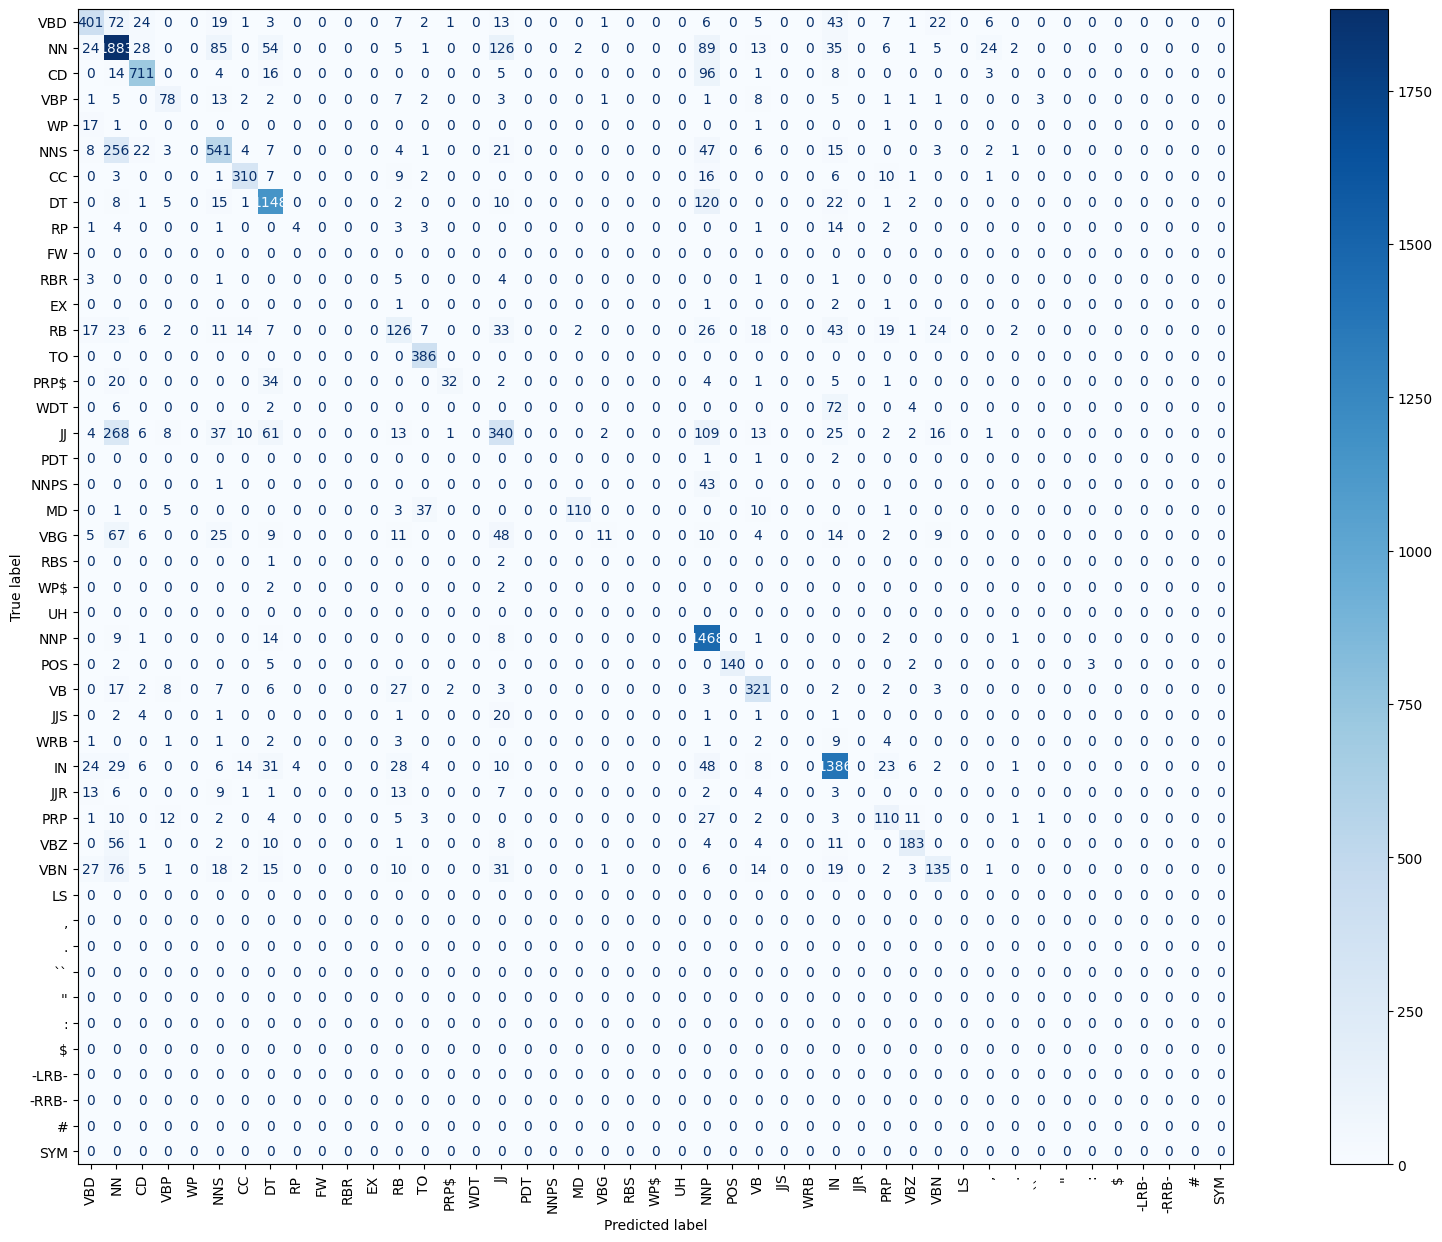

In [229]:
labels = valid_labels + punctuation_tags
encoded_labels = list(label_tokenizer.tokens_to_ids(labels))

fig, ax = plt.subplots(figsize=(25,15))
cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=encoded_labels)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(cmap='Blues', xticks_rotation='vertical', ax=ax);

# 2 Model Selection and Hypeparameters Tuning

In [263]:
class MyHyperModel(keras_tuner.HyperModel):
  def __init__(self, model_factory: ModelFactory, architectures: Dict[str, Dict], compile_info: dict, evaluation_fn=None) -> None:
    super().__init__()
    self.model_factory = model_factory
    self.architectures = architectures
    self.compile_info = compile_info
    self.evaluation_fn = evaluation_fn

  def build(self, hp: keras_tuner.HyperParameters) -> ks.Model:
    architecture = hp.Choice('architecture', list(models.keys()))
    hyperparameters={
        'rnn_units': hp.Int('rnn_units', min_value=32, max_value=512, step=32)
    }
    with hp.conditional_scope('architecture', 'additional_dense'):
      if architecture == 'additional_dense':
        hyperparameters['additional_dense_units'] = hp.Int('additional_dense_units', min_value=2, max_value=100, step=2)
      
    model.compile(**self.compile_info)

    return model

  def fit(self, hp: keras_tuner.HyperParameters, model: ks.Model, validation_data, *fit_args, **fit_kwargs):
    history = model.fit(*fit_args, validation_data=validation_data, **fit_kwargs)
    if self.evaluation_fn:
      return self.evaluation_fn(model, validation_data)
    else:
      return history


In [266]:
def evaluate(model:ks.Model, validation_data: tf.data.Dataset):
    _,_,results = evaluator.evaluate(model, validation_data, {'macro_f1': macro_f1})
    return -1 * results['macro_f1'] #tuner minimize the objective function

compile_info = {
    'optimizer': ks.optimizers.Adam(learning_rate=1e-3),
    'loss': 'categorical_crossentropy',
}

hypermodel = MyHyperModel(model_factory, architectures=models, compile_info=compile_info, evaluation_fn=evaluate)

In [267]:
trials = 2
epochs = 1
set_reproducibility(42)
tuner = keras_tuner.BayesianOptimization(
    hypermodel=hypermodel,
    # No objective to specify.
    # Objective is the return value of `HyperModel.fit()`.
    max_trials=trials,
    num_initial_points=None,
    project_name="tuning",
    overwrite=True,
    seed=current_seed()
)
tuner.search_space_summary()
tuner.search(x=train_dataloader, validation_data=val_dataloader, epochs=epochs)

Trial 2 Complete [00h 00m 26s]
default_objective: -0.026224849019060397

Best default_objective So Far: -0.026224849019060397
Total elapsed time: 00h 00m 52s
INFO:tensorflow:Oracle triggered exit


In [268]:
tuner.results_summary()

Results summary
Results in .\tuning
Showing 10 best trials
Trial summary
Hyperparameters:
architecture: additional_dense
rnn_units: 160
additional_dense_units: 90
Score: -0.026224849019060397
Trial summary
Hyperparameters:
architecture: base
rnn_units: 64
Score: -0.02600628543892498


In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))
model.fit(x=x_all, y=y_all, epochs=1)

TypeError: ignored